In [234]:
import numpy as np
import pandas as pd
from datetime import datetime
from scipy import sparse

import warnings
warnings.filterwarnings('ignore') 
from sklearn.exceptions import UndefinedMetricWarning

from wordcloud import WordCloud

from imblearn.under_sampling import ClusterCentroids, RandomUnderSampler 

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

from xgboost import XGBClassifier
from xgboost import plot_tree, plot_importance

import matplotlib.pyplot as plt
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import spacy
import nltk
from nltk.tokenize.toktok import ToktokTokenizer

import re
from bs4 import BeautifulSoup
import unicodedata

In [196]:
df = pd.read_csv('./cache/data_parsed.csv', encoding='utf-8')
print(df.shape)
df.tail()

(17996, 16)


,GICS Sector,date,Security,open,close,Daily Return,Label1Sig,Label2Sig,positive,negative,neutral,polarity,subjectivity,news,entities,tokens
17991,Information Technology,2016-07-01,68.0,79.797647,79.997795,0.250819,0.0,0.0,0.2,0.68,0.12,0.008778,0.195556,A 117-year-old woman in Mexico City finally re...,Mexico City Trinidad Alvarez Lira Athens Olym...,woman Mexico City finally received birth certi...
17992,Materials,2016-07-01,25.0,84.353162,84.231971,-0.143672,0.0,0.0,0.2,0.68,0.12,0.008778,0.195556,A 117-year-old woman in Mexico City finally re...,Mexico City Trinidad Alvarez Lira Athens Olym...,woman Mexico City finally received birth certi...
17993,Real Estate,2016-07-01,29.0,103.756666,103.449226,-0.296309,0.0,0.0,0.2,0.68,0.12,0.008778,0.195556,A 117-year-old woman in Mexico City finally re...,Mexico City Trinidad Alvarez Lira Athens Olym...,woman Mexico City finally received birth certi...
17994,Telecommunications Services,2016-07-01,5.0,36.905999,37.194000,0.780364,0.0,0.0,0.2,0.68,0.12,0.008778,0.195556,A 117-year-old woman in Mexico City finally re...,Mexico City Trinidad Alvarez Lira Athens Olym...,woman Mexico City finally received birth certi...
17995,Utilities,2016-07-01,28.0,61.591786,61.342143,-0.405319,0.0,0.0,0.2,0.68,0.12,0.008778,0.195556,A 117-year-old woman in Mexico City finally re...,Mexico City Trinidad Alvarez Lira Athens Olym...,woman Mexico City finally received birth certi...


## 3.1 Data analysis with sentiment already generated

In [197]:
X=df.iloc[:,0:13].drop(columns=['open','close','Security', 'Daily Return','Label1Sig','Label2Sig'])
y=df.iloc[:,[1,6]]
sigma='Label1Sig'

### 3.1.1 Normalize Data

In [130]:
y.head()

,date,Label1Sig
0,2010-01-04,0.0
1,2010-01-04,0.0
2,2010-01-04,1.0
3,2010-01-04,0.0
4,2010-01-04,0.0


In [132]:
std_scale = preprocessing.StandardScaler().fit(X.iloc[:,2:])
X_scaled = X
X_scaled.iloc[:,2:] = std_scale.transform(X.iloc[:,2:])
X_scaled['GICS Sector'] = 0.9+0.01*pd.Categorical(X_scaled['GICS Sector']).codes
X_scaled = X_scaled[['date','GICS Sector','positive','negative','neutral','polarity','subjectivity']]
X_scaled[-5:]

,date,GICS Sector,positive,negative,neutral,polarity,subjectivity
17991,2016-07-01,0.96,0.55296,1.002149,-1.597829,-0.116972,-0.909981
17992,2016-07-01,0.97,0.55296,1.002149,-1.597829,-0.116972,-0.909981
17993,2016-07-01,0.98,0.55296,1.002149,-1.597829,-0.116972,-0.909981
17994,2016-07-01,0.99,0.55296,1.002149,-1.597829,-0.116972,-0.909981
17995,2016-07-01,1.00,0.55296,1.002149,-1.597829,-0.116972,-0.909981


In [133]:
X_scaled.iloc[:,1:].head()

,GICS Sector,positive,negative,neutral,polarity,subjectivity
0,0.90,-0.514574,-1.240846,1.841413,-0.786789,0.722375
1,0.91,-0.514574,-1.240846,1.841413,-0.786789,0.722375
2,0.92,-0.514574,-1.240846,1.841413,-0.786789,0.722375
3,0.93,-0.514574,-1.240846,1.841413,-0.786789,0.722375
4,0.94,-0.514574,-1.240846,1.841413,-0.786789,0.722375


## 3.2 Setup methods

### 3.2.1 Time based Split by Date
Setup a split that creates a training set between the start and split date.  Create a test set between split and stop date.

In [134]:
tscv = TimeSeriesSplit(n_splits=7)
def time_train_test_split(start_date, split_date, stop_date):
    print('train', start_date, split_date, stop_date)
    X_train_time = X_scaled[(X_scaled['date'] >= start_date) & (X_scaled['date'] < split_date)]
    y_train_time = y[(y['date'] >= start_date) & (y['date'] < split_date)][sigma]
    X_test_time = X_scaled[(X_scaled['date'] >= split_date) & (X_scaled['date'] < stop_date)]
    y_test_time = y[(y['date'] >= split_date) & (y['date'] < stop_date)][sigma]
    return X_train_time, X_test_time, y_train_time, y_test_time

### 3.2.2 Train Model
Take in a model classifier and fit their training data and then make predictions based on the test set.

In [135]:
'''
Simple model to fit the training features utilizing a given model and make predictions
'''
def train_model(model, train_vect_x, train_y, test_vect_x):
    model = model.fit(train_vect_x, train_y)
    return model.predict(test_vect_x)

### 3.2.3 Sklearn scoring metrics

#### Score test takes in name/label to the scores and then wrongs a couple scoring models against them for comparison:
Accuracy: overall accuracy of classification
Precision: True Positive/(True Positive + False Positive)
Recall: True Positive/(True Positive + False Negative)
F1 Score: 2x Precision*Recall/(Precision+Recall)
Cohen kappa: (total accuracy - random accuracy)/(1 - random accuracy)
    Cohen's kappa is always less than or equal to 1.  Values of 0 or less, indicate that the classifier is useless.
    Values:
        <0           No agreement
        0-0.20       Slight
        0.21-0.40    Fair
        0.41-0.60    Moderate
        0.61-0.80    Substantial
        0.81-1.00    Perfect agreement

##### In the case of Financial stocks where we are determining whether to buy or sell a stock.  Quality is more important than quality.  It is better to be precise and specific about what we buy and sell then to correctly classify all data.  For the purpose of this evaluation Accuracy and Precision are the most important metrics.  As you will see the Cohen's kappa will be a combination of these 2 scores and is a good single measure for scoring this data

Kampakis, Dr. Stylianos (2016).  Performance Measures: Cohen's Kappa Statistic.  Retrieved on May 8, 2016 
from https://thedatascientist.com/performance-measures-cohens-kappa-statistic/

In [136]:
def score_test(name, y_test, y_predict):
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, labels=[-1,1], average='weighted')
    recall = recall_score(y_test, predictions, labels=[-1,1], average='weighted')
    f1 = f1_score(y_test, predictions, labels=[-1,1], average='weighted')
    cohen = cohen_kappa_score(y_test, predictions, labels=[-1,1])
    return {'Name': name, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1': f1, 'Cappa': cohen}

### 3.2.4 Stock scoring metrics

#### Classifies predictions based on whether it is a good or bad buy/hold/sell:
Label: Label that identifies the row in table
Good/Bad: Indicates whether the purchase or sale of stock was a good or bad choice<br>
    Good:<br>
        &emsp;Buy - Indicates predicted purchase was a good choice and would have made a profit<br>
        &emsp;Sell - Indicates predicted sell was a good choice and would have saved money<br>
        &emsp;Hold - Indicates that holding the stock or not purchasing the stock was a good choice<br>
        &emsp;Miss - 0 value.  Only applies to bad section.<br>
        &emsp;Total - Total good choices<br>
    Bad:<br>
        &emsp;Buy - Indicates predicted purchase was a bad choice and would have resulted in a loss<br>
        &emsp;Sell - Indicates predicted sell was a bad choice and would have resulted in loss of profit<br>
        &emsp;Hold - Indicates that predicted hold was a bad choice and would have resulted in missed profit or loss of money<br>
        &emsp;Miss - Indicates that predicted buy/sell transaction resulted in no change in stock price<br>
        &emsp;Total - Total bad choices<br>
    Total - totals of the good and bad choices for each column<br>
    True% - percentage of good and bad choices<br>
        
##### In my observation in order to maximize investment.  You would like to make good choices of when to buy and sell.  The higher the ratio of good buy/sell options you make the better you are to invest.  

Bad holds are ok because you will never be able to predict all the stocks that will go up and down.  In terms of the Miss category, these are transactions that netted no real change.  If you have many Misses you will take hit on transaction fees

As a small investor you will be hit with transaction fees the more investments you make.  When listening to traders they say it is much more important to minimize risk.  The ones that take high risk receive high reward but do not last

In [137]:
def stock_score(label, y_test, y_predict):
    conf_matrix = pd.crosstab(y_test, predictions, rownames=["Actual"], colnames=["Predicted"])
    if conf_matrix.shape[0] < 3 | conf_matrix.shape[1] < 3:
        return   # if predictions are all 1 value then do not print
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
        conf_arr = [
            {
                'Label': label, 'Good/Bad': 'Good',
                'Buy': conf_matrix.get(1,{}).get(1,0),
                'Sell': conf_matrix.get(-1,{}).get(-1,0),
                'Hold': conf_matrix.get(0,{}).get(0,0),
                'Miss': 0,
                'Total': conf_matrix.get(1,{}).get(1,0)+conf_matrix.get(-1,{}).get(-1,0)+conf_matrix.get(0,{}).get(0,0)
            },
            {
                'Label': label, 'Good/Bad': 'Bad',
                'Buy': conf_matrix.get(1,{}).get(-1,0),
                'Sell': conf_matrix.get(-1,{}).get(1,0),
                'Hold': conf_matrix.get(0,{}).get(1,0)+conf_matrix.get(0,{}).get(-1,0),
                'Miss': conf_matrix.get(1,{}).get(0,0)+conf_matrix.get(-1,{}).get(0,0),
                'Total': conf_matrix.iloc[1,:].sum()
            }
        ]
        conf_arr.append({'Label': label+' Total', 'Good/Bad': '',
                        'Buy': conf_arr[0]['Buy'] + conf_arr[1]['Buy'],
                        'Sell': conf_arr[0]['Sell'] + conf_arr[1]['Sell'],
                        'Hold': conf_arr[0]['Hold'] + conf_arr[1]['Hold'],
                        'Miss': conf_arr[0]['Miss'] + conf_arr[1]['Miss'],
                        'Total': conf_arr[0]['Total'] + conf_arr[1]['Total']
                        })
        conf_arr.append({'Label': label+' %', 'Good/Bad': 'True%',
                        'Buy': round(100*conf_arr[0]['Buy'] / conf_arr[2]['Buy'] if conf_arr[2]['Buy'] else 0),
                        'Sell': round(100*conf_arr[0]['Sell'] / conf_arr[2]['Sell'] if conf_arr[2]['Sell'] else 0),
                        'Hold': round(100*conf_arr[0]['Hold'] / conf_arr[2]['Hold']),
                        'Miss': round(100*conf_arr[1]['Miss'] / conf_arr[2]['Hold']),
                        'Total': round(100*conf_arr[0]['Total'] / conf_arr[2]['Total'])
                        })
        return conf_arr

## 3.3 Run sentiment classifiers

### 3.3.1 Rolling window with XGBClassifier and preprocessed sentiment

In [138]:
model = XGBClassifier()
score_df = pd.DataFrame(columns=['Name', 'Accuracy','Precision','Recall','F1','Cappa'])
conf_df = pd.DataFrame(columns=['Label', 'Good/Bad','Buy','Sell','Hold','Miss','Total'])

step = 90
walkforward=30
ddates = X['date'].unique()
for index in range(step, len(ddates), step):
    if (index+walkforward) > len(ddates):
        break #for not going over index out of range
    
    X_train_time, X_test_time, y_train_time, y_test_time = time_train_test_split(ddates[index-step], ddates[index], ddates[index+walkforward])  

    label = str(ddates[index-step])
    predictions = train_model(model, X_train_time.iloc[:,1:], y_train_time, X_test_time.iloc[:,1:])
    score = score_test(label, y_test_time, predictions)
    score_df = score_df.append(score, ignore_index=True)
    conf_df = conf_df.append(stock_score(label,y_test_time,predictions))

train 2010-01-04 2010-05-13 2010-06-25
train 2010-05-13 2010-09-21 2010-11-02
train 2010-09-21 2011-01-28 2011-03-14
train 2011-01-28 2011-06-08 2011-07-21
train 2011-06-08 2011-10-14 2011-11-28
train 2011-10-14 2012-02-24 2012-04-09
train 2012-02-24 2012-07-03 2012-08-15
train 2012-07-03 2012-11-12 2012-12-26
train 2012-11-12 2013-03-25 2013-05-07
train 2013-03-25 2013-08-01 2013-09-13
train 2013-08-01 2013-12-09 2014-01-23
train 2013-12-09 2014-04-21 2014-06-03
train 2014-04-21 2014-08-27 2014-10-09
train 2014-08-27 2015-01-06 2015-02-19
train 2015-01-06 2015-05-15 2015-06-29
train 2015-05-15 2015-09-23 2015-11-04
train 2015-09-23 2016-02-02 2016-03-16


In [139]:
pd.crosstab(y_test_time, predictions, rownames=["Actual"], colnames=["Predicted"])

Predicted,-1.0,0.0,1.0
Actual,,,
-1.0,0,39,1
0.0,1,178,32
1.0,2,71,6


In [140]:
score_df

,Name,Accuracy,Precision,Recall,F1,Cappa
0,2010-01-04,0.400000,0.411042,0.155340,0.212432,0.167539
1,2010-05-13,0.657576,0.074130,0.129630,0.091274,-0.083333
2,2010-09-21,0.669697,0.000000,0.000000,0.000000,NaN
3,2011-01-28,0.715152,0.000000,0.000000,0.000000,NaN
4,2011-06-08,0.415152,0.135659,0.186047,0.151611,-0.205298
5,2011-10-14,0.836364,0.017677,0.030303,0.022329,0.000000
6,2012-02-24,0.696970,0.000000,0.000000,0.000000,-0.923077
7,2012-07-03,0.772727,0.000000,0.000000,0.000000,-0.800000
8,2012-11-12,0.709091,0.000000,0.000000,0.000000,NaN
9,2013-03-25,0.833333,0.000000,0.000000,0.000000,NaN


In [141]:
score_df.describe()

,Accuracy,Precision,Recall,F1,Cappa
count,17.000000,17.000000,17.000000,17.000000,9.000000
mean,0.685205,0.055972,0.037524,0.039123,-0.250965
std,0.142343,0.103187,0.060658,0.062521,0.369208
min,0.400000,0.000000,0.000000,0.000000,-0.923077
25%,0.606061,0.000000,0.000000,0.000000,-0.240602
50%,0.709091,0.000000,0.000000,0.000000,-0.173913
75%,0.821212,0.074130,0.050420,0.067512,0.000000
max,0.845455,0.411042,0.186047,0.212432,0.167539


In [142]:
conf_df[conf_df['Good/Bad'] == 'True%']

,Label,Good/Bad,Buy,Sell,Hold,Miss,Total
3,2010-01-04 %,True%,100.0,57.0,40.0,9.0,52.0
3,2010-05-13 %,True%,25.0,67.0,84.0,26.0,44.0
3,2010-09-21 %,True%,0.0,0.0,68.0,2.0,49.0
3,2011-01-28 %,True%,0.0,0.0,72.0,0.0,50.0
3,2011-06-08 %,True%,12.0,52.0,59.0,46.0,41.0
3,2011-10-14 %,True%,0.0,50.0,90.0,7.0,48.0
3,2012-02-24 %,True%,0.0,0.0,78.0,11.0,47.0
3,2012-07-03 %,True%,0.0,0.0,83.0,6.0,48.0
3,2012-11-12 %,True%,0.0,0.0,75.0,6.0,48.0
3,2013-03-25 %,True%,0.0,0.0,85.0,2.0,49.0


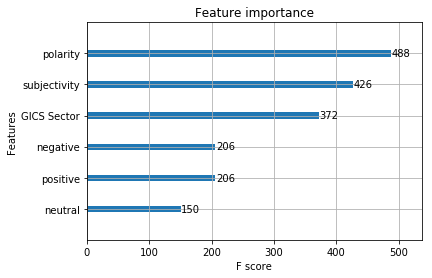

In [143]:
plot_importance(model, max_num_features=10)
plt.show()

#### XGBoost split without text features
It looks like the polarity and subjectivity had the highest correlations followed by the GICS sectors were the most important features when determining the F score.  However, the low precision and cappa score indicate it is still no better than random classification

### 3.3.2 Rolling window with DecisionTreeClassifier and preprocessed sentiment

In [144]:
model = DecisionTreeClassifier()
score_df = pd.DataFrame(columns=['Name', 'Accuracy','Precision','Recall','F1','Cappa'])
conf_df = pd.DataFrame(columns=['Label', 'Good/Bad','Buy','Sell','Hold','Miss','Total'])

step = 90
walkforward=30
ddates = X['date'].unique()
for index in range(step, len(ddates), step):
    if (index+walkforward) > len(ddates):
        break #for not going over index out of range
    
    X_train_time, X_test_time, y_train_time, y_test_time = time_train_test_split(ddates[index-step], ddates[index], ddates[index+walkforward])  

    label = str(ddates[index-step])
    predictions = train_model(model, X_train_time.iloc[:,1:], y_train_time, X_test_time.iloc[:,1:])
    score = score_test(label, y_test_time, predictions)
    score_df = score_df.append(score, ignore_index=True)
    conf_df = conf_df.append(stock_score(label,y_test_time,predictions))

train 2010-01-04 2010-05-13 2010-06-25
train 2010-05-13 2010-09-21 2010-11-02
train 2010-09-21 2011-01-28 2011-03-14
train 2011-01-28 2011-06-08 2011-07-21
train 2011-06-08 2011-10-14 2011-11-28
train 2011-10-14 2012-02-24 2012-04-09
train 2012-02-24 2012-07-03 2012-08-15
train 2012-07-03 2012-11-12 2012-12-26
train 2012-11-12 2013-03-25 2013-05-07
train 2013-03-25 2013-08-01 2013-09-13
train 2013-08-01 2013-12-09 2014-01-23
train 2013-12-09 2014-04-21 2014-06-03
train 2014-04-21 2014-08-27 2014-10-09
train 2014-08-27 2015-01-06 2015-02-19
train 2015-01-06 2015-05-15 2015-06-29
train 2015-05-15 2015-09-23 2015-11-04
train 2015-09-23 2016-02-02 2016-03-16


In [145]:
X_train_time.head()

,date,GICS Sector,positive,negative,neutral,polarity,subjectivity
15840,2015-09-23,0.90,1.086727,-0.119349,-0.738019,1.085025,1.083191
15841,2015-09-23,0.91,1.086727,-0.119349,-0.738019,1.085025,1.083191
15842,2015-09-23,0.92,1.086727,-0.119349,-0.738019,1.085025,1.083191
15843,2015-09-23,0.93,1.086727,-0.119349,-0.738019,1.085025,1.083191
15844,2015-09-23,0.94,1.086727,-0.119349,-0.738019,1.085025,1.083191


In [146]:
pd.crosstab(y_test_time, predictions, rownames=["Actual"], colnames=["Predicted"])

Predicted,-1.0,0.0,1.0
Actual,,,
-1.0,9,26,5
0.0,36,117,58
1.0,22,45,12


In [147]:
score_df

,Name,Accuracy,Precision,Recall,F1,Cappa
0,2010-01-04,0.406061,0.387392,0.271845,0.319335,0.105606
1,2010-05-13,0.445455,0.082812,0.277778,0.126450,-0.059829
2,2010-09-21,0.563636,0.143798,0.116505,0.128641,-0.200000
3,2011-01-28,0.572727,0.166104,0.161290,0.163425,0.151832
4,2011-06-08,0.424242,0.257528,0.333333,0.285805,0.390181
5,2011-10-14,0.627273,0.008838,0.030303,0.013685,-0.666667
6,2012-02-24,0.581818,0.203674,0.275362,0.229141,0.646154
7,2012-07-03,0.566667,0.052434,0.142857,0.069060,-0.117647
8,2012-11-12,0.660606,0.071124,0.065789,0.068353,0.000000
9,2013-03-25,0.657576,0.055877,0.106383,0.072956,-0.086957


In [148]:
score_df.describe()

,Accuracy,Precision,Recall,F1,Cappa
count,17.000000,17.000000,17.000000,17.000000,17.000000
mean,0.566845,0.131596,0.150588,0.130894,-0.033295
std,0.103211,0.094533,0.093156,0.086303,0.277633
min,0.406061,0.008838,0.030303,0.013685,-0.666667
25%,0.475758,0.055877,0.075472,0.069636,-0.117647
50%,0.572727,0.133659,0.116505,0.117839,-0.059829
75%,0.657576,0.166104,0.214876,0.163425,0.000000
max,0.724242,0.387392,0.333333,0.319335,0.646154


In [149]:
conf_df[conf_df['Good/Bad'] == 'True%']

,Label,Good/Bad,Buy,Sell,Hold,Miss,Total
3,2010-01-04 %,True%,46.0,64.0,42.0,25.0,52.0
3,2010-05-13 %,True%,38.0,56.0,85.0,93.0,35.0
3,2010-09-21 %,True%,41.0,38.0,70.0,21.0,45.0
3,2011-01-28 %,True%,44.0,73.0,72.0,26.0,44.0
3,2011-06-08 %,True%,83.0,70.0,58.0,62.0,41.0
3,2011-10-14 %,True%,0.0,14.0,90.0,40.0,41.0
3,2012-02-24 %,True%,100.0,64.0,79.0,40.0,42.0
3,2012-07-03 %,True%,33.0,44.0,83.0,44.0,41.0
3,2012-11-12 %,True%,100.0,0.0,75.0,14.0,46.0
3,2013-03-25 %,True%,57.0,33.0,85.0,29.0,43.0


#### DecisionTree Classification with preprocessed sentiment
While the Cappa score improved it was still no better than random classification.  It was able to classify more data, however the Misses were greater than the True positives and would cause no gains.  Still prefer XGB

## 3.4 Try to Tokenize the text

### 3.4.1 Count and TF-IDF Vectorizers with tokens

In [166]:
cv = CountVectorizer(stop_words='english', ngram_range=(1,3), max_features=10000, lowercase=True, token_pattern=r'\b[^\d\W]+\b')
tv = TfidfVectorizer(analyzer='word',min_df=0.0, max_df=1.0, ngram_range=(1,3), token_pattern=r'\w{1,}', sublinear_tf=True, max_features=10000)

In [212]:
X_scaled['tokens'] = df['tokens']
X_scaled.head()

,date,GICS Sector,positive,negative,neutral,polarity,subjectivity,news,tokens
0,2010-01-04,0.90,-0.514574,-1.240846,1.841413,-0.786789,0.722375,"New airport scanners break child porn laws', I...",airport scanners break child porn laws eye cl...
1,2010-01-04,0.91,-0.514574,-1.240846,1.841413,-0.786789,0.722375,"New airport scanners break child porn laws', I...",airport scanners break child porn laws eye cl...
2,2010-01-04,0.92,-0.514574,-1.240846,1.841413,-0.786789,0.722375,"New airport scanners break child porn laws', I...",airport scanners break child porn laws eye cl...
3,2010-01-04,0.93,-0.514574,-1.240846,1.841413,-0.786789,0.722375,"New airport scanners break child porn laws', I...",airport scanners break child porn laws eye cl...
4,2010-01-04,0.94,-0.514574,-1.240846,1.841413,-0.786789,0.722375,"New airport scanners break child porn laws', I...",airport scanners break child porn laws eye cl...


In [168]:
cv.fit(df['tokens'])
tv.fit(df['tokens'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=10000,
                min_df=0.0, ngram_range=(1, 3), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=True, token_pattern='\\w{1,}', tokenizer=None,
                use_idf=True, vocabulary=None)

In [213]:
model = XGBClassifier()
score_df = pd.DataFrame(columns=['Name', 'Accuracy','Precision','Recall','F1','Cappa'])
conf_df = pd.DataFrame(columns=['Label', 'Good/Bad','Buy','Sell','Hold','Miss','Total'])

step = 90
walkforward=30
ddates = X['date'].unique()
for index in range(step, len(ddates), step):
    if (index+walkforward) > len(ddates):
        break #for not going over index out of range
    
    X_train_time, X_test_time, y_train_time, y_test_time = time_train_test_split(ddates[index-step], ddates[index], ddates[index+walkforward])  

    tv_train_features = tv.fit_transform(X_train_time['tokens'])
    X_train_df = pd.DataFrame(X_train_time.iloc[:,1:7].values, columns=['GICS Sector','Positive','Negative','Neutral','Polarity','Subjectivity'])
    X_train_df = pd.concat([X_train_df, pd.DataFrame(tv_train_features.toarray(), columns=tv.get_feature_names())], axis=1)

    tv_test_features = tv.transform(X_test_time['tokens'])
    X_test_df = pd.DataFrame(X_test_time.iloc[:,1:7].values, columns=['GICS Sector','Positive','Negative','Neutral','Polarity','Subjectivity'])
    X_test_df = pd.concat([X_test_df, pd.DataFrame(tv_test_features.toarray(), columns=tv.get_feature_names())], axis=1)
    
    label = str(ddates[index-step])
    predictions = train_model(model, X_train_df.iloc[:,1:], y_train_time, X_test_df.iloc[:,1:])
    score = score_test(label, y_test_time, predictions)
    score_df = score_df.append(score, ignore_index=True)
    conf_df = conf_df.append(stock_score(label,y_test_time,predictions))

train 2010-01-04 2010-05-13 2010-06-25
train 2010-05-13 2010-09-21 2010-11-02
train 2010-09-21 2011-01-28 2011-03-14
train 2011-01-28 2011-06-08 2011-07-21
train 2011-06-08 2011-10-14 2011-11-28
train 2011-10-14 2012-02-24 2012-04-09
train 2012-02-24 2012-07-03 2012-08-15
train 2012-07-03 2012-11-12 2012-12-26
train 2012-11-12 2013-03-25 2013-05-07
train 2013-03-25 2013-08-01 2013-09-13
train 2013-08-01 2013-12-09 2014-01-23
train 2013-12-09 2014-04-21 2014-06-03
train 2014-04-21 2014-08-27 2014-10-09
train 2014-08-27 2015-01-06 2015-02-19
train 2015-01-06 2015-05-15 2015-06-29
train 2015-05-15 2015-09-23 2015-11-04
train 2015-09-23 2016-02-02 2016-03-16


In [214]:
pd.crosstab(y_test_time, predictions, rownames=["Actual"], colnames=["Predicted"])

Predicted,0.0
Actual,
-1.0,40
0.0,211
1.0,79


In [215]:
score_df

,Name,Accuracy,Precision,Recall,F1,Cappa
0,2010-01-04,0.409091,0.616505,0.053398,0.098283,NaN
1,2010-05-13,0.806061,0.000000,0.000000,0.000000,0.0
2,2010-09-21,0.687879,0.000000,0.000000,0.000000,NaN
3,2011-01-28,0.709091,0.172043,0.043011,0.068817,NaN
4,2011-06-08,0.621212,0.554968,0.186047,0.276356,1.0
5,2011-10-14,0.900000,0.000000,0.000000,0.000000,NaN
6,2012-02-24,0.757576,0.000000,0.000000,0.000000,NaN
7,2012-07-03,0.830303,0.000000,0.000000,0.000000,NaN
8,2012-11-12,0.769697,0.000000,0.000000,0.000000,NaN
9,2013-03-25,0.830303,0.000000,0.000000,0.000000,0.0


In [216]:
score_df.describe()

,Accuracy,Precision,Recall,F1,Cappa
count,17.000000,17.000000,17.000000,17.000000,3.000000
mean,0.739929,0.079030,0.016615,0.026086,0.333333
std,0.123265,0.195494,0.046517,0.070356,0.577350
min,0.409091,0.000000,0.000000,0.000000,0.000000
25%,0.666667,0.000000,0.000000,0.000000,0.000000
50%,0.757576,0.000000,0.000000,0.000000,0.000000
75%,0.830303,0.000000,0.000000,0.000000,0.500000
max,0.900000,0.616505,0.186047,0.276356,1.000000


In [217]:
conf_df[conf_df['Good/Bad'] == 'True%']

,Label,Good/Bad,Buy,Sell,Hold,Miss,Total
3,2010-01-04 %,True%,0,100.0,39.0,0.0,52.0
3,2010-05-13 %,True%,0,0.0,83.0,3.0,49.0
3,2010-09-21 %,True%,0,0.0,69.0,0.0,50.0
3,2011-01-28 %,True%,0,100.0,72.0,2.0,50.0
3,2011-06-08 %,True%,100,100.0,63.0,7.0,50.0
3,2011-10-14 %,True%,0,0.0,90.0,0.0,50.0
3,2012-02-24 %,True%,0,0.0,78.0,3.0,49.0
3,2012-07-03 %,True%,0,0.0,83.0,0.0,50.0
3,2012-11-12 %,True%,0,0.0,77.0,0.0,50.0
3,2013-03-25 %,True%,0,0.0,86.0,3.0,49.0


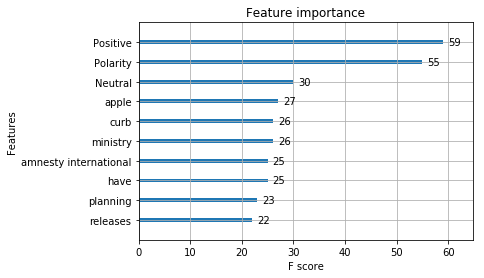

In [218]:
plot_importance(model, max_num_features=10)

### 3.4.2 Count Vectorizer with tokens

In [219]:
model = XGBClassifier()
score_df = pd.DataFrame(columns=['Name', 'Accuracy','Precision','Recall','F1','Cappa'])
conf_df = pd.DataFrame(columns=['Label', 'Good/Bad','Buy','Sell','Hold','Miss','Total'])

step = 90
walkforward=30
ddates = X['date'].unique()
for index in range(step, len(ddates), step):
    if (index+walkforward) > len(ddates):
        break #for not going over index out of range
    
    X_train_time, X_test_time, y_train_time, y_test_time = time_train_test_split(ddates[index-step], ddates[index], ddates[index+walkforward])  

    cv_train_features = cv.fit_transform(X_train_time['tokens'])
    X_train_df = pd.DataFrame(X_train_time.iloc[:,1:7].values, columns=['GICS Sector','Positive','Negative','Neutral','Polarity','Subjectivity'])
    X_train_df = pd.concat([X_train_df, pd.DataFrame(cv_train_features.toarray(), columns=cv.get_feature_names())], axis=1)

    cv_test_features = cv.transform(X_test_time['tokens'])
    X_test_df = pd.DataFrame(X_test_time.iloc[:,1:7].values, columns=['GICS Sector','Positive','Negative','Neutral','Polarity','Subjectivity'])
    X_test_df = pd.concat([X_test_df, pd.DataFrame(cv_test_features.toarray(), columns=cv.get_feature_names())], axis=1)
    
    label = str(ddates[index-step])
    predictions = train_model(model, X_train_df.iloc[:,1:], y_train_time, X_test_df.iloc[:,1:])
    score = score_test(label, y_test_time, predictions)
    score_df = score_df.append(score, ignore_index=True)
    conf_df = conf_df.append(stock_score(label,y_test_time,predictions))

train 2010-01-04 2010-05-13 2010-06-25
train 2010-05-13 2010-09-21 2010-11-02
train 2010-09-21 2011-01-28 2011-03-14
train 2011-01-28 2011-06-08 2011-07-21
train 2011-06-08 2011-10-14 2011-11-28
train 2011-10-14 2012-02-24 2012-04-09
train 2012-02-24 2012-07-03 2012-08-15
train 2012-07-03 2012-11-12 2012-12-26
train 2012-11-12 2013-03-25 2013-05-07
train 2013-03-25 2013-08-01 2013-09-13
train 2013-08-01 2013-12-09 2014-01-23
train 2013-12-09 2014-04-21 2014-06-03
train 2014-04-21 2014-08-27 2014-10-09
train 2014-08-27 2015-01-06 2015-02-19
train 2015-01-06 2015-05-15 2015-06-29
train 2015-05-15 2015-09-23 2015-11-04
train 2015-09-23 2016-02-02 2016-03-16


In [220]:
pd.crosstab(y_test_time, predictions, rownames=["Actual"], colnames=["Predicted"])

Predicted,-1.0,0.0
Actual,,
-1.0,7,33
0.0,4,207
1.0,0,79


In [221]:
score_df

,Name,Accuracy,Precision,Recall,F1,Cappa
0,2010-01-04,0.409091,0.308252,0.053398,0.091028,0.000000
1,2010-05-13,0.806061,0.000000,0.000000,0.000000,0.000000
2,2010-09-21,0.687879,0.000000,0.000000,0.000000,NaN
3,2011-01-28,0.718182,0.000000,0.000000,0.000000,NaN
4,2011-06-08,0.548485,0.143763,0.124031,0.133170,-0.075472
5,2011-10-14,0.900000,0.000000,0.000000,0.000000,NaN
6,2012-02-24,0.790909,0.000000,0.000000,0.000000,NaN
7,2012-07-03,0.830303,0.000000,0.000000,0.000000,NaN
8,2012-11-12,0.769697,0.000000,0.000000,0.000000,NaN
9,2013-03-25,0.830303,0.000000,0.000000,0.000000,0.000000


In [222]:
score_df.describe()

,Accuracy,Precision,Recall,F1,Cappa
count,17.000000,17.000000,17.000000,17.000000,4.000000
mean,0.738681,0.039172,0.013897,0.018616,-0.018868
std,0.128866,0.091977,0.033923,0.042311,0.037736
min,0.409091,0.000000,0.000000,0.000000,-0.075472
25%,0.666667,0.000000,0.000000,0.000000,-0.018868
50%,0.769697,0.000000,0.000000,0.000000,0.000000
75%,0.830303,0.000000,0.000000,0.000000,0.000000
max,0.900000,0.308252,0.124031,0.133170,0.000000


In [223]:
conf_df[conf_df['Good/Bad'] == 'True%']

,Label,Good/Bad,Buy,Sell,Hold,Miss,Total
3,2010-01-04 %,True%,0,50.0,40.0,0.0,52.0
3,2010-05-13 %,True%,0,0.0,83.0,3.0,49.0
3,2010-09-21 %,True%,0,0.0,69.0,0.0,50.0
3,2011-01-28 %,True%,0,0.0,72.0,0.0,50.0
3,2011-06-08 %,True%,94,0.0,60.0,13.0,47.0
3,2011-10-14 %,True%,0,0.0,90.0,0.0,50.0
3,2012-02-24 %,True%,0,0.0,79.0,0.0,50.0
3,2012-07-03 %,True%,0,0.0,83.0,0.0,50.0
3,2012-11-12 %,True%,0,0.0,77.0,0.0,50.0
3,2013-03-25 %,True%,0,0.0,86.0,3.0,49.0


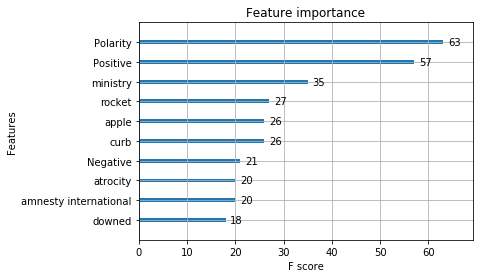

In [224]:
plot_importance(model, max_num_features=10)
plt.show()

### 3.4.3 XGBoost with full text

In [225]:
cv = CountVectorizer(stop_words='english', ngram_range=(1,3), max_features=10000, lowercase=True, token_pattern=r'\b[^\d\W]+\b')
tv = TfidfVectorizer(analyzer='word',min_df=0.0, max_df=1.0, ngram_range=(1,3), token_pattern=r'\w{1,}', sublinear_tf=True, max_features=10000)
cv.fit(df['news'])
tv.fit(df['news'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=10000,
                min_df=0.0, ngram_range=(1, 3), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=True, token_pattern='\\w{1,}', tokenizer=None,
                use_idf=True, vocabulary=None)

In [182]:
X_scaled = X_scaled.drop(columns=['tokens'])
X_scaled['news']=df['news']
X_scaled.head()

,date,GICS Sector,positive,negative,neutral,polarity,subjectivity,news
0,2010-01-04,0.90,-0.514574,-1.240846,1.841413,-0.786789,0.722375,"New airport scanners break child porn laws', I..."
1,2010-01-04,0.91,-0.514574,-1.240846,1.841413,-0.786789,0.722375,"New airport scanners break child porn laws', I..."
2,2010-01-04,0.92,-0.514574,-1.240846,1.841413,-0.786789,0.722375,"New airport scanners break child porn laws', I..."
3,2010-01-04,0.93,-0.514574,-1.240846,1.841413,-0.786789,0.722375,"New airport scanners break child porn laws', I..."
4,2010-01-04,0.94,-0.514574,-1.240846,1.841413,-0.786789,0.722375,"New airport scanners break child porn laws', I..."


In [226]:
model = XGBClassifier()
score_df = pd.DataFrame(columns=['Name', 'Accuracy','Precision','Recall','F1','Cappa'])
conf_df = pd.DataFrame(columns=['Label', 'Good/Bad','Buy','Sell','Hold','Miss','Total'])

step = 90
walkforward=30
ddates = X['date'].unique()
for index in range(step, len(ddates), step):
    if (index+walkforward) > len(ddates):
        break #for not going over index out of range
    
    X_train_time, X_test_time, y_train_time, y_test_time = time_train_test_split(ddates[index-step], ddates[index], ddates[index+walkforward])  

    tv_train_features = tv.fit_transform(X_train_time['news'])
    X_train_df = pd.DataFrame(X_train_time.iloc[:,1:7].values, columns=['GICS Sector','Positive','Negative','Neutral','Polarity','Subjectivity'])
    X_train_df = pd.concat([X_train_df, pd.DataFrame(tv_train_features.toarray(), columns=tv.get_feature_names())], axis=1)

    tv_test_features = tv.transform(X_test_time['news'])
    X_test_df = pd.DataFrame(X_test_time.iloc[:,1:7].values, columns=['GICS Sector','Positive','Negative','Neutral','Polarity','Subjectivity'])
    X_test_df = pd.concat([X_test_df, pd.DataFrame(tv_test_features.toarray(), columns=tv.get_feature_names())], axis=1)
    
    label = str(ddates[index-step])
    predictions = train_model(model, X_train_df.iloc[:,1:], y_train_time, X_test_df.iloc[:,1:])
    score = score_test(label, y_test_time, predictions)
    score_df = score_df.append(score, ignore_index=True)
    conf_df = conf_df.append(stock_score(label,y_test_time,predictions))

train 2010-01-04 2010-05-13 2010-06-25
train 2010-05-13 2010-09-21 2010-11-02
train 2010-09-21 2011-01-28 2011-03-14
train 2011-01-28 2011-06-08 2011-07-21
train 2011-06-08 2011-10-14 2011-11-28
train 2011-10-14 2012-02-24 2012-04-09
train 2012-02-24 2012-07-03 2012-08-15
train 2012-07-03 2012-11-12 2012-12-26
train 2012-11-12 2013-03-25 2013-05-07
train 2013-03-25 2013-08-01 2013-09-13
train 2013-08-01 2013-12-09 2014-01-23
train 2013-12-09 2014-04-21 2014-06-03
train 2014-04-21 2014-08-27 2014-10-09
train 2014-08-27 2015-01-06 2015-02-19
train 2015-01-06 2015-05-15 2015-06-29
train 2015-05-15 2015-09-23 2015-11-04
train 2015-09-23 2016-02-02 2016-03-16


In [227]:
pd.crosstab(y_test_time, predictions, rownames=["Actual"], colnames=["Predicted"])

Predicted,0.0
Actual,
-1.0,40
0.0,211
1.0,79


In [228]:
score_df

,Name,Accuracy,Precision,Recall,F1,Cappa
0,2010-01-04,0.375758,0.000000,0.000000,0.000000,NaN
1,2010-05-13,0.806061,0.000000,0.000000,0.000000,0.000000
2,2010-09-21,0.687879,0.000000,0.000000,0.000000,NaN
3,2011-01-28,0.718182,0.000000,0.000000,0.000000,NaN
4,2011-06-08,0.484848,0.059901,0.038760,0.047065,-0.555985
5,2011-10-14,0.900000,0.000000,0.000000,0.000000,NaN
6,2012-02-24,0.790909,0.000000,0.000000,0.000000,NaN
7,2012-07-03,0.796970,0.000000,0.000000,0.000000,NaN
8,2012-11-12,0.769697,0.000000,0.000000,0.000000,NaN
9,2013-03-25,0.857576,0.000000,0.000000,0.000000,NaN


In [229]:
score_df.describe()

,Accuracy,Precision,Recall,F1,Cappa
count,17.000000,17.000000,17.000000,17.000000,3.000000
mean,0.729768,0.005663,0.003350,0.004195,-0.185328
std,0.142606,0.016518,0.010131,0.012509,0.320998
min,0.375758,0.000000,0.000000,0.000000,-0.555985
25%,0.639394,0.000000,0.000000,0.000000,-0.277992
50%,0.769697,0.000000,0.000000,0.000000,0.000000
75%,0.839394,0.000000,0.000000,0.000000,0.000000
max,0.900000,0.059901,0.038760,0.047065,0.000000


In [230]:
conf_df[conf_df['Good/Bad'] == 'True%']

,Label,Good/Bad,Buy,Sell,Hold,Miss,Total
3,2010-01-04 %,True%,0,0,38.0,0.0,50.0
3,2010-05-13 %,True%,0,0,83.0,3.0,49.0
3,2010-09-21 %,True%,0,0,69.0,0.0,50.0
3,2011-01-28 %,True%,0,0,72.0,0.0,50.0
3,2011-06-08 %,True%,22,0,61.0,18.0,44.0
3,2011-10-14 %,True%,0,0,90.0,0.0,50.0
3,2012-02-24 %,True%,0,0,79.0,0.0,50.0
3,2012-07-03 %,True%,0,0,82.0,3.0,49.0
3,2012-11-12 %,True%,0,0,77.0,0.0,50.0
3,2013-03-25 %,True%,0,0,86.0,0.0,50.0


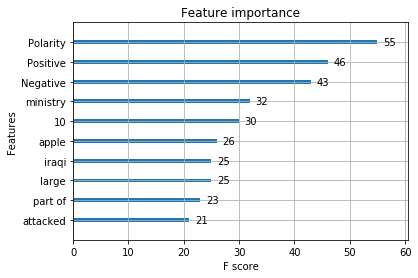

In [231]:
plot_importance(model, max_num_features=10)
plt.show()

### 3.4.4 Utilize XGBoost with tokens and rolling windows with corpus
Evaluate whether the sentiment scores affected the feature importnace of the data

In [238]:
nlp = spacy.load('en', parse=True, tag=True, entity=True)
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

In [239]:
ps = nltk.porter.PorterStemmer()
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]'
    if remove_digits == True:
        pattern = r'[^a-zA-z\s]'
    
    text = re.sub(pattern, '', text)
    return text

def simple_stemmer(text):
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

text = X_news.iloc[0,1]
# remove_special_characters(text, True)
# simple_stemmer(text)
# lemmatize_text(text)
remove_stopwords(text)

'New airport scanners break child porn laws \' , Indian eye clinic founded single doc treated 27 million patients , performed 3 million life-changing eye surgeries , slightly cost meal McDonalds. ( Video ) \' , president Iceland refuses sign legislation reimbuse nearly $ 5.7bn lost British Dutch savers failed Icelandic banks. \' , 87 % illiterate , 1 3 experience physical , psychological sexual violence , 44 yrs average life expectancy rate , 70 - 80 % face forced marriages ... Afghan women \' , Russia follows EU rejecting US poultry imports chlorine washing , may not allow current 30,000 tonne import country. \' lot meat. " , Teenager killed girlfriend dousing petrol setting alight sentenced least 21 years behind bars \' , Sweden allows wolf hunting 45 year 237 wolves entire nation many \' , BBC News staff photographer accosted police ... taking picture ... sunset ... one Londons biggest tourist attractions. Bloody cretins. \' , Another New Years Eve , another round car torchings Fran

In [240]:
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

In [250]:
X_news = df[['date','GICS Sector', 'news']]
X_news.head()

,date,GICS Sector,news
0,2010-01-04,Consumer Discretionary,"New airport scanners break child porn laws', I..."
1,2010-01-04,Consumer Staples,"New airport scanners break child porn laws', I..."
2,2010-01-04,Energy,"New airport scanners break child porn laws', I..."
3,2010-01-04,Financials,"New airport scanners break child porn laws', I..."
4,2010-01-04,Health Care,"New airport scanners break child porn laws', I..."


In [251]:
X_news['corpus'] = normalize_corpus(X_news['news'], text_lower_case=False, text_lemmatization=False, special_char_removal=False)

In [245]:
cv = CountVectorizer(stop_words='english', ngram_range=(1,3), max_features=10000, lowercase=True, token_pattern=r'\b[^\d\W]+\b')
tv = TfidfVectorizer(analyzer='word',min_df=0.0, max_df=1.0, ngram_range=(1,3), token_pattern=r'\w{1,}', sublinear_tf=True, max_features=10000)

tscv = TimeSeriesSplit(n_splits=7)
def time_train_test_split_xy(X,y,start_date, split_date, stop_date):
#     print('train', start_date, split_date, stop_date)
    X_train_time = X[(X['date'] >= start_date) & (X['date'] < split_date)]
    y_train_time = y[(y['date'] >= start_date) & (y['date'] < split_date)][sigma]
    X_test_time = X[(X['date'] >= split_date) & (X['date'] < stop_date)]
    y_test_time = y[(y['date'] >= split_date) & (y['date'] < stop_date)][sigma]
    return X_train_time, X_test_time, y_train_time, y_test_time

In [252]:
model = XGBClassifier()
score_df = pd.DataFrame(columns=['Name', 'Accuracy','Precision','Recall','F1','Cappa'])
conf_df = pd.DataFrame(columns=['Label', 'Good/Bad','Buy','Sell','Hold','Miss','Total'])

step = 90
walkforward=30
ddates = X['date'].unique()
for index in range(step, len(ddates), step):
    if (index+walkforward) > len(ddates):
        break #for not going over index out of range
    
    X_train_time, X_test_time, y_train_time, y_test_time = time_train_test_split_xy(X_news,y,ddates[index-step], ddates[index], ddates[index+walkforward])  

    tv_train_features = tv.fit_transform(X_train_time['corpus'])
    X_train_df = pd.DataFrame(X_train_time.iloc[:,1].values, columns=['GICS Sector'])
    X_train_df = pd.concat([X_train_df, pd.DataFrame(tv_train_features.toarray(), columns=tv.get_feature_names())], axis=1)

    tv_test_features = tv.transform(X_test_time['corpus'])
    X_test_df = pd.DataFrame(X_test_time.iloc[:,1].values, columns=['GICS Sector'])
    X_test_df = pd.concat([X_test_df, pd.DataFrame(tv_test_features.toarray(), columns=tv.get_feature_names())], axis=1)
    
    label = str(ddates[index-step])
    predictions = train_model(model, X_train_df.iloc[:,1:], y_train_time, X_test_df.iloc[:,1:])
    score = score_test(label, y_test_time, predictions)
    score_df = score_df.append(score, ignore_index=True)
    conf_df = conf_df.append(stock_score(label,y_test_time,predictions))

In [253]:
pd.crosstab(y_test_time, predictions, rownames=["Actual"], colnames=["Predicted"])

Predicted,0.0
Actual,
-1.0,40
0.0,211
1.0,79


In [254]:
score_df

,Name,Accuracy,Precision,Recall,F1,Cappa
0,2010-01-04,0.375758,0.000000,0.000000,0.000000,NaN
1,2010-05-13,0.806061,0.000000,0.000000,0.000000,0.000000
2,2010-09-21,0.687879,0.000000,0.000000,0.000000,NaN
3,2011-01-28,0.684848,0.000000,0.000000,0.000000,NaN
4,2011-06-08,0.548485,0.196617,0.108527,0.139692,-0.285714
5,2011-10-14,0.900000,0.000000,0.000000,0.000000,NaN
6,2012-02-24,0.790909,0.000000,0.000000,0.000000,NaN
7,2012-07-03,0.796970,0.000000,0.000000,0.000000,NaN
8,2012-11-12,0.769697,0.000000,0.000000,0.000000,NaN
9,2013-03-25,0.830303,0.000000,0.000000,0.000000,0.000000


In [255]:
score_df.describe()

,Accuracy,Precision,Recall,F1,Cappa
count,17.000000,17.000000,17.000000,17.000000,3.000000
mean,0.732264,0.011566,0.006384,0.008217,-0.095238
std,0.133999,0.047687,0.026322,0.033880,0.164957
min,0.375758,0.000000,0.000000,0.000000,-0.285714
25%,0.666667,0.000000,0.000000,0.000000,-0.142857
50%,0.769697,0.000000,0.000000,0.000000,0.000000
75%,0.830303,0.000000,0.000000,0.000000,0.000000
max,0.900000,0.196617,0.108527,0.139692,0.000000


In [256]:
conf_df[conf_df['Good/Bad'] == 'True%']

,Label,Good/Bad,Buy,Sell,Hold,Miss,Total
3,2010-01-04 %,True%,0,0,38.0,0.0,50.0
3,2010-05-13 %,True%,0,0,83.0,3.0,49.0
3,2010-09-21 %,True%,0,0,69.0,0.0,50.0
3,2011-01-28 %,True%,0,0,71.0,3.0,49.0
3,2011-06-08 %,True%,8,65,63.0,13.0,47.0
3,2011-10-14 %,True%,0,0,90.0,0.0,50.0
3,2012-02-24 %,True%,0,0,79.0,0.0,50.0
3,2012-07-03 %,True%,0,0,82.0,3.0,49.0
3,2012-11-12 %,True%,0,0,77.0,0.0,50.0
3,2013-03-25 %,True%,0,0,86.0,3.0,49.0


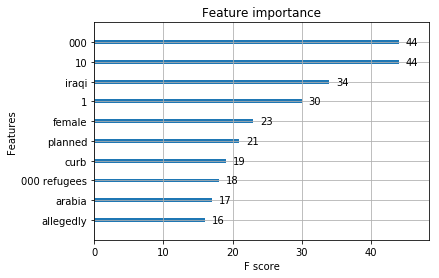

In [257]:
plot_importance(model, max_num_features=10)
plt.show()

## 3.5 Conclusion cleaning sentiment does not fix issue
Clearly even though we generated a sentiment, polarity and subjectivity score in preprocessing.  It clearly did not give enough make any difference in the precision and Kappa score.  The model did not converge when utilizing sentiment scores, tagging or named entities.

For future research it may make sense to retrieve financial news that pertains to the research and weight the articles based on views.  It would also make sense to do a historical finding and see if the past 5,30,90 days has a direct affect on the stock. 